In [1]:
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
import argparse
from IPython.display import clear_output
from numpy.random import random_sample
import matplotlib
from astropy.io import fits
from matplotlib.colors import LogNorm


In [2]:
def Sersic_sigma(half_light_re,n,pixel_scale,sigma):
    light_profile = galsim.Sersic(n, half_light_radius=half_light_re)
    image = light_profile.drawImage(scale = pixel_scale,method='no_pixel')
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

def Kolmogorov_sigma(half_light_re,pixel_scale,sigma):
    light_profile = galsim.Kolmogorov(half_light_radius=half_light_re)
    image = light_profile.drawImage(scale = pixel_scale,method='no_pixel')
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

def OpticalPSF_sigma(fwhm,pixel_scale,sigma):
    light_profile = galsim.OpticalPSF(fwhm)
    image = light_profile.drawImage(scale = pixel_scale,method='no_pixel')
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

def Gaussian_sigma(sigma,pixel_scale):
    light_profile = galsim.Gaussian(sigma)
    image = light_profile.drawImage(scale = pixel_scale,method='no_pixel')
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale

In [14]:
class PSFSameSecondTest:
    
    def __init__(self, gal_type, gal_sigma,e1,e2,psf_type,psf_sigma,psf_e1,psf_e2,
                gal_flux=1.e2,pixel_scale = 0.2,sersicn = -1,subtract_intersection = True):
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.psf_type = psf_type
        self.psf_sigma = psf_sigma
        self.psf_model_sigma = psf_sigma
        self.psf_e1 = psf_e1
        self.psf_e2 = psf_e2
        self.psf_model_e1 = psf_e1
        self.psf_model_e2 = psf_e2
        self.gal_flux=gal_flux
        self.pixel_scale = pixel_scale
        self.e1 = e1
        self.e2 = e2
        self.e = np.sqrt(e1**2+e2**2)
        self.sersicn=sersicn
        self.e_truth = np.sqrt(e1**2+e2**2)
        self.subtract_intersection = subtract_intersection
        if gal_type == "gaussian":
            self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
        elif gal_type == "sersic":
            self.gal_light = self.findAdaptiveSersic(gal_sigma)
        
        self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
            
        
        if psf_type == "gaussian":
            self.psf_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
            self.psf_model_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
        elif psf_type == "kolmogorov":
            self.psf_light = self.findAdaptiveKolmogorov(self.psf_sigma)
            self.psf_model_light = galsim.Gaussian(flux = 1.0, sigma = self.psf_model_sigma)
        elif psf_type == "opticalPSF":
            self.psf_light = self.findAdaptiveOpticalPSF(self.psf_sigma)
            self.psf_model_light = galsim.Gaussian(flux = 1.0, sigma = self.psf_model_sigma)
            
        self.psf_light = self.psf_light.shear(e1=psf_e1, e2=psf_e2)
        self.psf_model_light = self.psf_model_light.shear(e1=self.psf_model_e1,e2=self.psf_model_e2)
            
            
    def get_intersection(self):
        image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        results = galsim.hsm.EstimateShear(image,image_epsf)
        intersection = np.sqrt(results.corrected_e1**2+results.corrected_e2**2)-self.e_truth
        return intersection
    
    def get_prediction(self):
        return self.e_truth*(self.psf_model_sigma**2-self.psf_sigma**2)/self.gal_sigma**2 + (self.psf_sigma/self.gal_sigma)**2*(self.psf_e2-self.psf_model_e2)
    
    def get_measurement(self):
        image_epsf = self.psf_model_light.drawImage(scale = self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        results = galsim.hsm.EstimateShear(image,image_epsf)
        bias = np.sqrt(results.corrected_e1**2+results.corrected_e2**2)-self.e_truth
        if self.subtract_intersection==True:
            return bias-self.get_intersection()
        else:
            return bias
    
    def findAdaptiveSersic(self,sigma):
        good_half_light_re = bisect(Sersic_sigma,max(self.gal_sigma/5,self.pixel_scale),self.gal_sigma*5,args=(self.sersicn,self.pixel_scale,sigma))
        return galsim.Sersic(n=self.sersicn,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,max(self.psf_sigma/5,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,max(self.psf_sigma/3,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale)
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_results(self):
        results = dict()
        results["prediction"] = self.get_prediction()
        results["measurement"] = self.get_measurement()

        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        results["gal_sigma"] = self.gal_sigma
        results["psf_sigma"] = self.psf_sigma
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["e"] = self.e
        results["sersicn"] = self.sersicn
        results["psf_e1"] = self.psf_e1
        results["psf_e2"] = self.psf_e2
        
        results["psf_model_sigma"] = self.psf_model_sigma
        results["psf_model_e1"] = self.psf_model_e1
        results["psf_model_e2"] = self.psf_model_e2

        
        results["prediction-error"] = results["prediction"]-results["measurement"]
        results["prediction-percenterror"] = results["prediction-error"]/results["e"]
        
        return results
    
    
    
    
    
    



1. make gaussian PSF pixel responsive.

2. make size of galaxy PSF and pixel more realistic. 

        a. PSF: ~0.7'' FWHM -> ~0.3’‘ sigma

        b. Pixel scale: 0.2''

        c. Typical ellipticity of galaxy 0.28

        d. Galaxy size is going to vary from (0.75~3)*PSF size
        make galaxy size smaller

3. Look at optical PSF after pixel response 





In [4]:
test1 = PSFSameSecondTest("sersic",0.5,0.0,0.28,                       #gal_type,gal_sigma,e1,e2
                "opticalPSF",0.3,0.0,0.0,
                sersicn=1.5,subtract_intersection=False)           #psf_type,psf_sigma,size_error

print test1.get_results()

{'psf_model_sigma': 0.3, 'e': 0.28, 'psf_type': 'opticalPSF', 'psf_model_e1': 0.0, 'prediction-error': 0.0037123847007750066, 'gal_sigma': 0.5, 'psf_e1': 0.0, 'prediction': 0.0, 'sersicn': 1.5, 'measurement': -0.0037123847007750066, 'prediction-percenterror': 0.013258516788482165, 'psf_e2': 0.0, 'e2': 0.28, 'e1': 0.0, 'psf_model_e2': 0.0, 'psf_sigma': 0.3, 'gal_type': 'sersic'}


comment: A debug test

intersection : bias for model==truth

Currently, PSF model just match the truth size, and shear the same way as the truth





In [5]:
# different type of galaxy and different type of psf light profile, but with 2.0 gal_sig and 0.6 psf_sig
#       gal_type   ,gal_sig,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test2= [("gaussian" ,0.5    ,0.0,0.28,"gaussian"  ,0.3     ,0.0,0.0,{'subtract_intersection':True}),
       ("gaussian" ,0.5    ,0.0,0.28,"kolmogorov" ,0.3     ,0.0,0.0,{'subtract_intersection':True}),
       ("gaussian" ,0.5    ,0.0,0.28,"opticalPSF" ,0.3     ,0.0,0.0,{'subtract_intersection':True}),
       ("sersic"   ,0.5    ,0.0,0.28,"gaussian"   ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,0.5    ,0.0,0.28,"kolmogorov" ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,0.5    ,0.0,0.28,"opticalPSF" ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,0.5    ,0.0,0.28,"gaussian"   ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
       ("sersic"   ,0.5    ,0.0,0.28,"kolmogorov" ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
       ("sersic"   ,0.5    ,0.0,0.28,"opticalPSF" ,0.3     ,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
      ]

In [6]:
test2result = []
for i in range(len(test2)):
    test = PSFSameSecondTest(*test2[i][:-1],**test2[i][-1])
    results = test.get_results()
    test2result.append(results)

In [7]:
print 'galaxy sigma = {} arcsec, e2={}, PSF sigma = {} arcsec.'.format(0.5,0.28,0.3)

for i in range(len(test2result)):
    results = test2result[i]
    print 'Galaxy:{}, PSF type:{}, percentage error of ellipticity: {:.2f}%'.format(results['gal_type'],results['psf_type'],results['measurement']/results['e2']*100)
    
    
    

galaxy sigma = 0.5 arcsec, e2=0.28, PSF sigma = 0.3 arcsec.
Galaxy:gaussian, PSF type:gaussian, percentage error of ellipticity: 0.00%
Galaxy:gaussian, PSF type:kolmogorov, percentage error of ellipticity: -4.31%
Galaxy:gaussian, PSF type:opticalPSF, percentage error of ellipticity: 2.21%
Galaxy:sersic, PSF type:gaussian, percentage error of ellipticity: 0.00%
Galaxy:sersic, PSF type:kolmogorov, percentage error of ellipticity: -4.56%
Galaxy:sersic, PSF type:opticalPSF, percentage error of ellipticity: -0.03%
Galaxy:sersic, PSF type:gaussian, percentage error of ellipticity: 0.00%
Galaxy:sersic, PSF type:kolmogorov, percentage error of ellipticity: -4.87%
Galaxy:sersic, PSF type:opticalPSF, percentage error of ellipticity: -1.34%


Comment:

Sanity chck: Gaussian PSF have 0 bias when repalced by the same Gaussian

At a first glance, the wrongness of e2 does NOT depend a lot on the type of galaxy

But they depend on type of PSF by a lot (of course)

Gonna make sure that it does not depend on size ratio

In [18]:
#gal_sigma varies from 0.6 arcsec to 3 arcsec, for sersic n = 3 galaxy on gaussian psf (1 arcsec)
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test3 = [("sersic"   ,0.2+0.05*i    ,0.0,0.28,"kolmogorov" ,0.5   ,0.0,0.0,{'subtract_intersection':True,'sersicn':3}) for i in range(20)
      ]

In [19]:
test3result=[]
for i in range(len(test3)):
    test = PSFSameSecondTest(*test3[i][:-1],**test3[i][-1])
    results = test.get_results()
    test3result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test3)*100)+"%")

Finished 100.0%


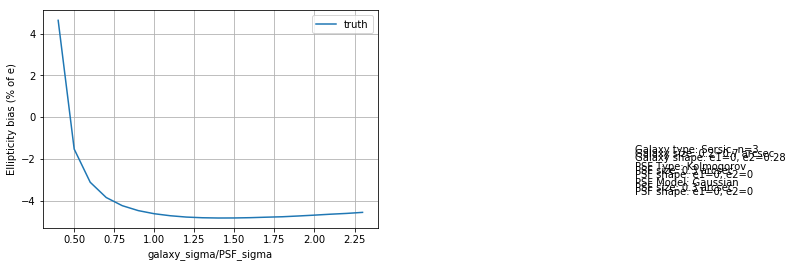

In [20]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test3result],100*np.array([t["measurement"]/t['e2'] for t in test3result]),label='truth')
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias (% of e)")
plt.legend()

xpos=4

ypos=-1.5

plt.text(xpos,ypos-0.2,"Galaxy type: Sersic, n=3")
plt.text(xpos,ypos-0.4,"Galaxy size: 0.2~0.7 arcsec")
plt.text(xpos,ypos-0.6,"Galaxy shape: e1=0, e2=0.28")


plt.text(xpos,ypos-1,"PSF Type: Kolmogorov")
plt.text(xpos,ypos-1.2,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-1.4,"PSF shape: e1=0, e2=0")

plt.text(xpos,ypos-1.8,"PSF Model: Gaussian")
plt.text(xpos,ypos-2,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-2.2,"PSF shape: e1=0, e2=0")



plt.grid()
plt.show()

Turns out when we fix the PSF truth and model, change the galaxy size, the dependence of the bias on the size ratio is non-linear. Don't really know what this function is. Should we try to fit it?

Comment:

When changing the size of PSF, the trend is the same for size ratio. They both reach the maximum bias at G/P ~1.5




In [ ]:
#Sersic galaxy (2.0 arcsec) but different n (from 1 to 3), on gaussian psf, test how bad the prediction on Sersic profile
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test4 = [("sersic"   ,0.5    ,0.0,0.28,"kolmogorov" ,0.3 ,0.0,0.0,{'subtract_intersection':True,'sersicn':0.5+0.2*i,'pixel_scale':0.2}) for i in range(14)
      ]

In [ ]:
test4result=[]
for i in range(len(test4)):
    test = PSFSameSecondTest(*test4[i][:-1],**test4[i][-1])
    results = test.get_results()
    test4result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test4)*100)+"%")

In [10]:
plt.plot([t['sersicn'] for t in test4result],100*np.array([t["measurement"]/t['e2'] for t in test4result]),label='truth')
plt.xlabel("Sersic n")
plt.ylabel("Ellipticity bias (% of e)")
plt.legend()

xpos=4

ypos=-3.3


plt.text(xpos,ypos-0.2,"Galaxy size: 0.5 arcsec")
plt.text(xpos,ypos-0.3,"Galaxy shape: e1=0, e2=0.28")


plt.text(xpos,ypos-0.4,"PSF Type: Kolmogorov")
plt.text(xpos,ypos-0.5,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-0.6,"PSF shape: e1=0, e2=0")

plt.text(xpos,ypos-0.8,"PSF Model: Gaussian")
plt.text(xpos,ypos-0.9,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-1,"PSF shape: e1=0, e2=0")



plt.grid()
plt.show()

NameError: name 'test4result' is not defined

In [123]:
#gal_sigma varies from 0.6 arcsec to 3 arcsec, for sersic n = 3 galaxy on gaussian psf (1 arcsec)
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test5 = [("sersic"   ,0.2+0.05*i    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0.0,{'subtract_intersection':True,'sersicn':3}) for i in range(20)
      ]

In [124]:
test5result=[]
for i in range(len(test5)):
    test = PSFSameSecondTest(*test5[i][:-1],**test5[i][-1])
    results = test.get_results()
    test5result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test5)*100)+"%")

Finished 100.0%


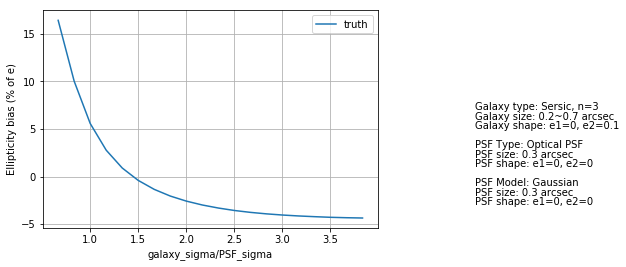

In [105]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],100*np.array([t["measurement"]/t['e2'] for t in test5result]),label='truth')
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias (% of e)")
plt.legend()

xpos=5

ypos=8

plt.text(xpos,ypos-1,"Galaxy type: Sersic, n=3")
plt.text(xpos,ypos-2,"Galaxy size: 0.2~0.7 arcsec")
plt.text(xpos,ypos-3,"Galaxy shape: e1=0, e2=0.1")


plt.text(xpos,ypos-5,"PSF Type: Optical PSF")
plt.text(xpos,ypos-6,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-7,"PSF shape: e1=0, e2=0")

plt.text(xpos,ypos-9,"PSF Model: Gaussian")
plt.text(xpos,ypos-10,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-11,"PSF shape: e1=0, e2=0")



plt.grid()
plt.show()

Comments:

The optical PSF went insane when repalced by Gaussian.  Seems that it has a larger higher moments. This also largely depend on the size of the PSF.

I don't understand why the bias in OPSF is size dependent but Kolmogorov isn't

In [117]:
# See if 
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test51 = [("sersic"   ,0.2+0.05*i    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0.05,{'subtract_intersection':True,'sersicn':3}) for i in range(20)]+[("sersic"   ,0.2+0.05*i    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0.1,{'subtract_intersection':True,'sersicn':3}) for i in range(20)]+[("sersic"   ,0.2+0.05*i    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0.2,{'subtract_intersection':True,'sersicn':3}) for i in range(20)]+[("sersic"   ,0.2+0.05*i    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0.4,{'subtract_intersection':True,'sersicn':3}) for i in range(20)]








In [118]:
test51result=[]
for i in range(len(test51)):
    test1 = PSFSameSecondTest(*test51[i][:-1],**test51[i][-1])

    test51result.append(test1.get_results())
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test51)*100)+"%")

Finished 100.0%


In [119]:
test6result1=test51result[0:20]
test6result2=test51result[20:40]
test6result3=test51result[40:60]
test6result4=test51result[60:80]

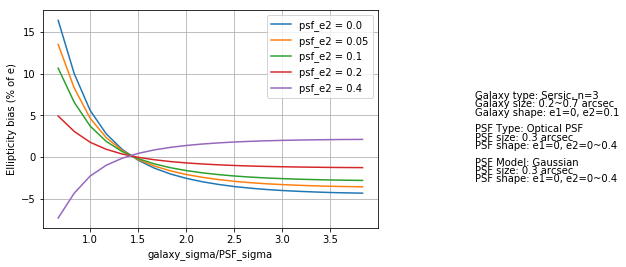

In [178]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],100*np.array([t["measurement"]/t['e2'] for t in test5result]),label='psf_e2 = 0.0')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result1],100*np.array([t["measurement"]/t['e2'] for t in test6result1]),label='psf_e2 = 0.05')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result2],100*np.array([t["measurement"]/t['e2'] for t in test6result2]),label='psf_e2 = 0.1')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result3],100*np.array([t["measurement"]/t['e2'] for t in test6result3]),label='psf_e2 = 0.2')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result4],100*np.array([t["measurement"]/t['e2'] for t in test6result4]),label='psf_e2 = 0.4')

plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias (% of e)")
plt.legend()

xpos=5

ypos=8

plt.text(xpos,ypos-1,"Galaxy type: Sersic, n=3")
plt.text(xpos,ypos-2,"Galaxy size: 0.2~0.7 arcsec")
plt.text(xpos,ypos-3,"Galaxy shape: e1=0, e2=0.1")


plt.text(xpos,ypos-5,"PSF Type: Optical PSF")
plt.text(xpos,ypos-6,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-7,"PSF shape: e1=0, e2=0~0.4")

plt.text(xpos,ypos-9,"PSF Model: Gaussian")
plt.text(xpos,ypos-10,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-11,"PSF shape: e1=0, e2=0~0.4")



plt.grid()
plt.show()

In [125]:
#gal_sigma varies from 0.6 arcsec to 3 arcsec, for sersic n = 3 galaxy on gaussian psf (1 arcsec)
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test7 = [("sersic"   ,0.9    ,0.0,0.28,"opticalPSF" ,0.3   ,0.0,0+0.05*i,{'subtract_intersection':True,'sersicn':3}) for i in range(12)
      ]

In [127]:
test7result=[]
for i in range(len(test7)):
    test = PSFSameSecondTest(*test7[i][:-1],**test7[i][-1])
    results = test.get_results()
    test7result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test7)*100)+"%")

Finished 100.0%


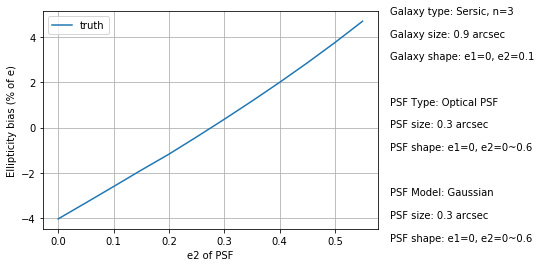

In [177]:
plt.plot([t['psf_e2'] for t in test7result],100*np.array([t["measurement"]/t['e2'] for t in test7result]),label='truth')
plt.xlabel("e2 of PSF")
plt.ylabel("Ellipticity bias (% of e)")
plt.legend()

xpos=0.6

ypos=6

plt.text(xpos,ypos-1,"Galaxy type: Sersic, n=3")
plt.text(xpos,ypos-2,"Galaxy size: 0.9 arcsec")
plt.text(xpos,ypos-3,"Galaxy shape: e1=0, e2=0.1")


plt.text(xpos,ypos-5,"PSF Type: Optical PSF")
plt.text(xpos,ypos-6,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-7,"PSF shape: e1=0, e2=0~0.6")

plt.text(xpos,ypos-9,"PSF Model: Gaussian")
plt.text(xpos,ypos-10,"PSF size: 0.3 arcsec")
plt.text(xpos,ypos-11,"PSF shape: e1=0, e2=0~0.6")



plt.grid()
plt.show()

empirecally estimate the effect vs higher moments (4th) ,estimateShear() in galsim?

In [189]:
teste = PSFSameSecondTest("sersic",0.5,0.0,0.28,                       #gal_type,gal_sigma,e1,e2
                "kolmogorov",0.6,0.0,0.0,
                sersicn=1.5,subtract_intersection=False)           #psf_type,psf_sigma,size_error

g = 0.5

psf1 = galsim.Gaussian(sigma=0.3)
psf2 = teste.psf_light

psf1 = psf1.shear(g1 = 0.0,g2 = g)
psf2 = psf2.shear(g1 = 0.0,g2 = g)


image1 = psf1.drawImage(scale = 0.2,method = 'no_pixel')
image2 = psf2.drawImage(scale = 0.2,method = 'no_pixel')

g1 = galsim.hsm.FindAdaptiveMom(image1).observed_shape
g2 = galsim.hsm.FindAdaptiveMom(image2).observed_shape

print  g1, g2
print (g1.g2-g2.g2)/g

galsim.Shear(g1=-7.4015684472e-17,g2=0.500008270245) galsim.Shear(g1=0.0,g2=0.499999950329)
1.66398306232e-05


A little note here:
    
    I use the same shear for PSF and PSF_model to make sure that they have the same 'observed_shape',  or the M_xy. Is this secure?

In [172]:
def view_image(image,size):
    
    
    image.write("image/view_image_parser.fits")
    hdu = fits.open('image/view_image_parser.fits')
    full_array = hdu[0].data
    length = len(full_array)
    
    if size > length:
        size = length
    
    crop_array = full_array[int(length/2-size/2):int(length/2+size/2),int(length/2-size/2):int(length/2+size/2)]
    plt.imshow(crop_array,norm = LogNorm())
    plt.show()


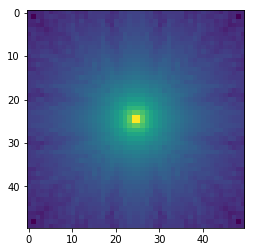

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.2 arcsec


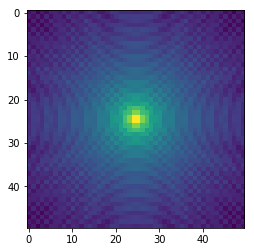

The image above is Optical PSF with fwhm = 0.3 and pixel scale = 0.2 arcsec


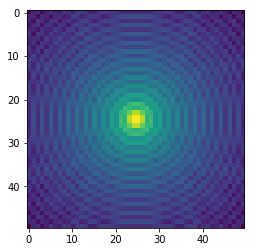

The image above is Optical PSF with fwhm = 0.4 and pixel scale = 0.2 arcsec


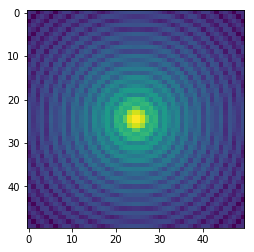

The image above is Optical PSF with fwhm = 0.5 and pixel scale = 0.2 arcsec


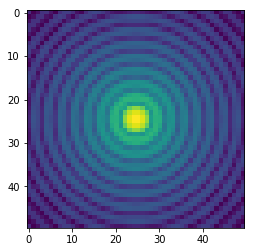

The image above is Optical PSF with fwhm = 0.6 and pixel scale = 0.2 arcsec


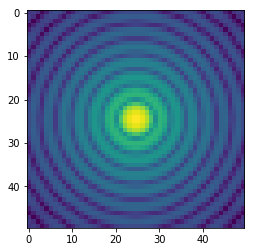

The image above is Optical PSF with fwhm = 0.7 and pixel scale = 0.2 arcsec


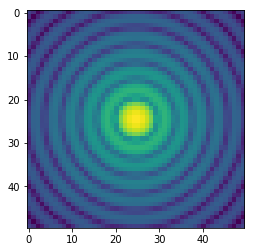

The image above is Optical PSF with fwhm = 0.8 and pixel scale = 0.2 arcsec


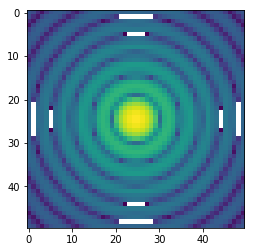

The image above is Optical PSF with fwhm = 0.9 and pixel scale = 0.2 arcsec


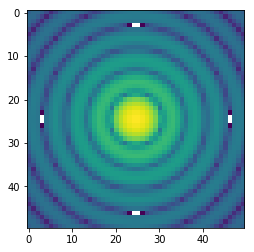

The image above is Optical PSF with fwhm = 1.0 and pixel scale = 0.2 arcsec


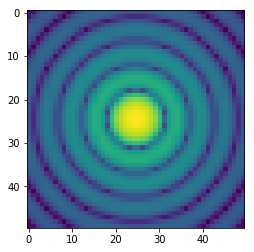

The image above is Optical PSF with fwhm = 1.1 and pixel scale = 0.2 arcsec


In [173]:
# Look at some optical PSF

for i in range(10):
    fwhm = 0.2+0.1*i
    pixel_scale = 0.2
    psf = galsim.OpticalPSF(fwhm)
    image = psf.drawImage(scale = pixel_scale)
    view_image(image,50)
    print 'The image above is Optical PSF with fwhm = {} and pixel scale = {} arcsec'.format(fwhm,pixel_scale)

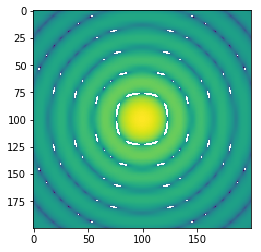

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.01 arcsec


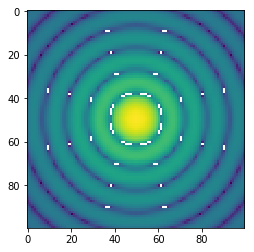

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.02 arcsec


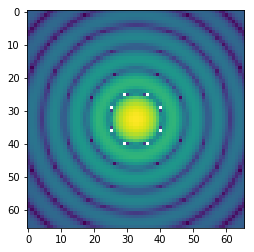

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.03 arcsec


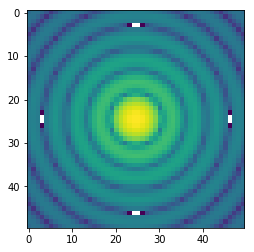

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.04 arcsec


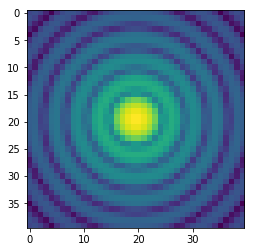

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.05 arcsec


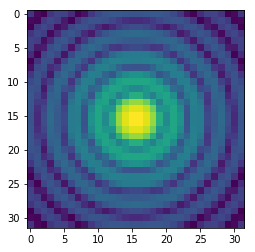

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.06 arcsec


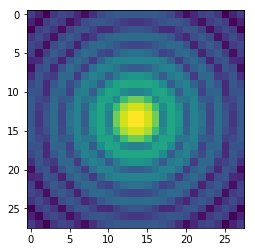

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.07 arcsec


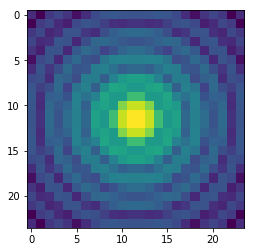

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.08 arcsec


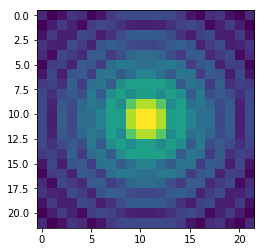

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.09 arcsec


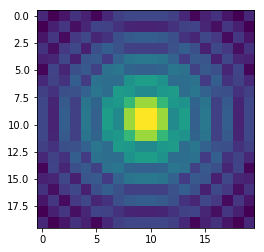

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.1 arcsec


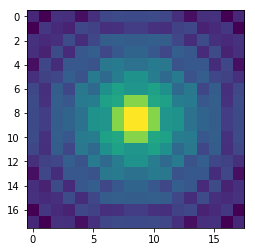

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.11 arcsec


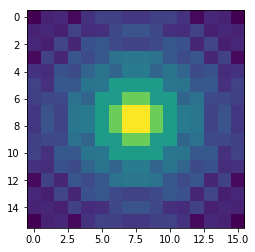

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.12 arcsec


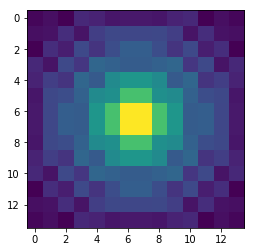

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.13 arcsec


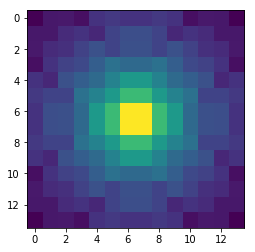

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.14 arcsec


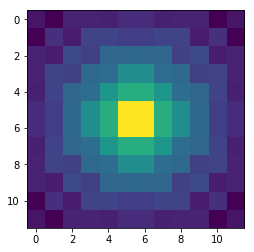

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.15 arcsec


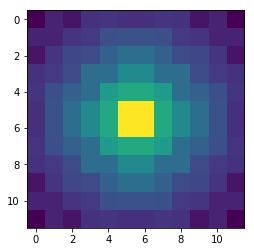

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.16 arcsec


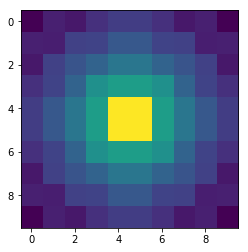

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.17 arcsec


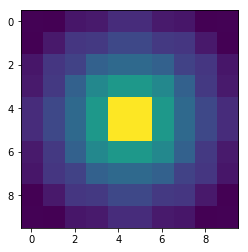

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.18 arcsec


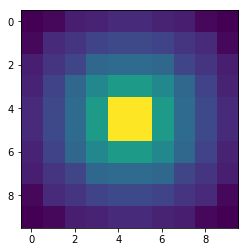

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.19 arcsec


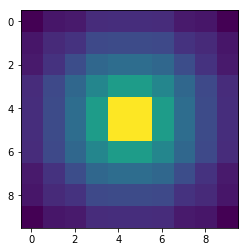

The image above is Optical PSF with fwhm = 0.2 and pixel scale = 0.2 arcsec


In [175]:
# Look at some optical PSF

for i in range(20):
    fwhm = 0.2
    pixel_scale = 0.01+0.01*i
    psf = galsim.OpticalPSF(fwhm)
    image = psf.drawImage(scale = pixel_scale)
    view_image(image,int(1/pixel_scale)*2)
    print 'The image above is Optical PSF with fwhm = {} and pixel scale = {} arcsec'.format(fwhm,pixel_scale)

things to do:

1. Galaxy, even smaller!

2. Explore the empirecal relation between higher moments and the effect
    no 3rd moment
    look at 4th moment
    
3. Move code to a cosmic shear estimator framework

4. Write a infomation broadcast function

5. github repo


